### Test tamaas viscoelastic function and compare with our validated script

In [33]:
import tamaas as tm
import matplotlib.pyplot as plt

import tamaas.utils
import numpy as np

tm.initialize(8)

# discretization
n = 512

##time
t0 = 0
t1 = 10 
time_steps = 20
dt = (t1 - t0)/time_steps
##load(constant)
W = 1e0  # Total load

L = 1.  # Domain size
Radius = 0.01 # Radius of contact area, here we apply a smaller radius to reduce the effect of periodicity

physical_size = [L, L]
discritization = [n, n]
model = tm.Model(tm.model_type.basic_2d, physical_size, discritization)

model.E = 3
model.nu = 0.5

E_star = model.E / (1 - model.nu**2)

shear_modulus = [2.75]
characteristic_time = [1]


In [34]:
'''
# Setup for contact
x = np.linspace(0,
                L,
                n,
                endpoint=False,
                dtype=tm.dtype)
y = np.linspace(0,
                L,
                n,
                endpoint=False,
                dtype=tm.dtype)
xx, yy = np.meshgrid(x, y, indexing='ij')

Radius = 0.1
surface = -((xx - L / 2)**2 +
            (yy - L / 2)**2) / (2 * Radius)
'''

# Scatter surface across MPI processes
#local_surface = tm.mpi.scatter(surface)

"\n# Setup for contact\nx = np.linspace(0,\n                L,\n                n,\n                endpoint=False,\n                dtype=tm.dtype)\ny = np.linspace(0,\n                L,\n                n,\n                endpoint=False,\n                dtype=tm.dtype)\nxx, yy = np.meshgrid(x, y, indexing='ij')\n\nRadius = 0.1\nsurface = -((xx - L / 2)**2 +\n            (yy - L / 2)**2) / (2 * Radius)\n"

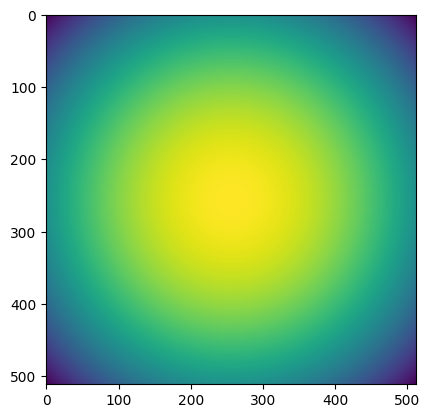

In [35]:
surface = tm.utils.hertz_surface(physical_size, discritization,Radius)

plt.imshow(surface)

In [36]:
#solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

In [37]:
Ac_tamaas = []

In [38]:
#solve for target pressure
p_target = W / (L**2) #avarge pressure
#solver.solve(p_target)

for t in np.linspace(t0, t1, time_steps):
    solver.solve(p_target)
    Ac_tamaas.append(np.mean(model.traction > 0)*L**2)

 Iter          Cost_f           Error


    0    3.811177e-02    5.287407e-01
   84    1.351317e+00    7.357295e-13
 Iter          Cost_f           Error
    0    8.127582e-01    8.272958e-03
   67    1.829522e+00    8.051494e-13
 Iter          Cost_f           Error
    0    1.088772e+00    6.585766e-03
   77    2.210525e+00    7.644605e-13
 Iter          Cost_f           Error
    0    1.311768e+00    5.219930e-03
   69    2.518543e+00    9.252965e-13
 Iter          Cost_f           Error
    0    1.494136e+00    4.144689e-03
   73    2.771079e+00    8.416534e-13
 Iter          Cost_f           Error
    0    1.644836e+00    3.282214e-03
   73    2.980565e+00    7.814282e-13
 Iter          Cost_f           Error
    0    1.770486e+00    2.618477e-03
   78    3.156030e+00    6.995756e-13
 Iter          Cost_f           Error
    0    1.876042e+00    2.120431e-03
   82    3.304149e+00    8.685822e-13
 Iter          Cost_f           Error
    0    1.965164e+00    1.707052e-03
   77    3.429934e+00    7.782947e-13
 Iter       

In [39]:

#load history from Week20
Ac = np.load('Ac_10seconds.npy')
pressure_distributions = np.load('pressure_distributions_10seconds.npy')

G_inf = model.mu
G = shear_modulus

print('G_inf:', G_inf, ' G: ' + str(G))

tau = characteristic_time#[1]#[0.1, 1] #relaxation time
eta = [g * t for g, t in zip(G, tau)]

print('tau:', tau, ' eta: ' + str(eta))

nu = 0.5

##Hertz solution at t0 
G_maxwell_t0 = 0
for k in range(len(G)):
    G_maxwell_t0 += G[k]
G_effective_t0 = G_inf + G_maxwell_t0
E_effective_t0 = 2*G_effective_t0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

Ac_Johnson_ref = []
g_1 = 2*(G[0] + G_inf)
g_2 = -g_1*(2*G_inf/(2*G_inf-g_1))

e_1 = 2 * (G[0] + G_inf) * (1+model.nu)
K = 2 * G_inf * (1+model.nu)
tau_c = [t*e_1/K for t in tau]

for t in np.arange(t0, t1, dt):        
    Ac_Johnson_ref.append((3/8 * Radius * W * (1/g_1 + 1/g_2*(1-np.exp(-t/tau_c[0]))))**(2/3)*np.pi)
tau_c

G_inf: 1.0  G: [2.75]
tau: [1]  eta: [2.75]


[3.75]

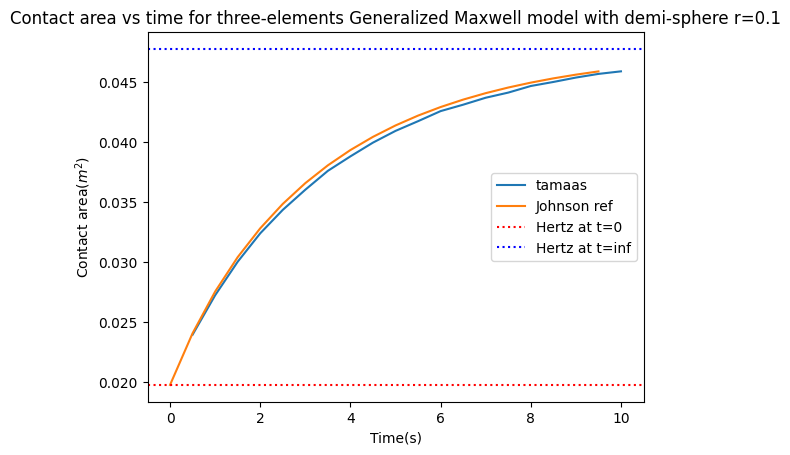

In [40]:
# Define the length of tangent lines
tangent_length = 0.6  # Smaller range for tangent line visualization

# Plot the tangent lines
#plt.plot([t0, t0 + tangent_length], [Ac[0], Ac[0] + slope_t0 * tangent_length], 'r--', label='Tangent at Start')

# Plot the reference tangent lines
#plt.axline([t0, Ac[0]], slope=slope_t0_ref, color='r', linestyle='-.',label='Tangent at Start (Ref)')
#plt.axline([t1, Ac[-1]], slope=slope_t1_ref, color='b', linestyle='-.', label='Tangent at End (Ref)')

# Plot the Johnson's solution
#plt.plot(np.arange(t0, t1, dt), Ac_Johnson_ref)

plt.plot(np.arange(t0, t1, dt)+dt, Ac_tamaas)
plt.plot(np.arange(t0, t1, dt), Ac_Johnson_ref)
plt.axhline(Ac_hertz_t0, color='red', linestyle='dotted')
plt.axhline(Ac_hertz_t_inf, color='blue', linestyle='dotted')
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.legend(["tamaas","Johnson ref", "Hertz at t=0", "Hertz at t=inf"])
#define a title that can read parameter tau_0
plt.title("Contact area vs time for three-elements Generalized Maxwell model with demi-sphere r=0.1")
#plt.axhline(Ac_hertz_t_inf, color='blue')
plt.show()